In [ ]:
import os
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import ImageFolder, CelebA
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd
from torchvision.io import read_image
from torchvision.transforms.functional import rotate
import torchvision
import json
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
a = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
b = torch.FloatTensor([2, 5, 8])
x = torch.sum(torch.ones(3, 3)*(a>b), axis=1)
t = torch.IntTensor([1, 2, 3])
torch.repeat_interleave(t, x.int())
torch.arange(3).repeat(3, 1)[a>b]
x

tensor([0., 1., 3.])

In [ ]:
def get_semi_hard_triplets(batch, labels, device):
  all_dists = torch.sum(torch.pow(batch.unsqueeze(1) - batch.unsqueeze(0), 2), axis=2).to(device)
  same_label_mask = torch.squeeze(torch.eq(labels.unsqueeze(1), labels.unsqueeze(0))).to(device)
  pos_mask = torch.squeeze(torch.logical_xor(same_label_mask, torch.eye(labels.size()[0]).to(device))) * (all_dists < 1)
  pos_i = torch.argmax(all_dists * pos_mask, axis=1).to(device)
  pos_indices = torch.arange(labels.shape[0]).to(device).repeat(labels.shape[0], 1)[pos_mask]
  pos_dists = all_dists[np.arange(all_dists.shape[0]), pos_i]
  all_dists[all_dists <= pos_dists.reshape((-1, 1))] = 1e9
  neg_indices = torch.argmin(all_dists, axis=1)
  repeat = torch.sum(torch.ones(labels.shape[0], labels.shape[0]).to(device)*pos_mask, axis=1)
  anc_indices = torch.repeat_interleave(torch.arange(batch.shape[0]).to(device), repeat.int())
  neg_indices = torch.repeat_interleave(neg_indices.to(device), repeat.int())

  return anc_indices, pos_indices, neg_indices

In [ ]:
class SimpleNet(nn.Module):
  def __init__(self) -> None:
    super().__init__()

    self.conv0 = nn.Sequential(
        nn.Conv2d(1, 32, 3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.conv1 = nn.Sequential(
        nn.Conv2d(32, 64, 2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(64, 128, 3),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(128, 256, 2),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(256, 4)

  def forward(self, X):
    X = self.conv0(X)
    X = self.conv1(X)
    X = self.conv2(X)
    X = self.conv3(X)
    X = self.flatten(X)
    X = self.fc(X)
    X = X/torch.norm(X)

    return X

In [ ]:
def get_mnist_triplet_batch(dataset, d):
  l = torch.IntTensor([]).view(0,)
  ret = torch.IntTensor([]).view(0,)
  for i in range(10):
    indices = torch.randint(len(d[i]), (100,))
    els = torch.tensor(d[i])[indices]
    num = torch.zeros(100, 1)+i
    l = torch.cat([l, els])
    ret = torch.cat([ret, num])
  perm = torch.randperm(l.shape[0])
  l = l[perm]
  ret = ret[perm]
  b = torch.FloatTensor([]).view(0, 1, 28, 28)
  for i in l:
    b = torch.cat([b, dataset[i.item()][0].unsqueeze(0)], axis=0)

  return b, ret

In [ ]:
def get_triplets(batch, labels, device):
  all_dists = torch.sum(torch.pow(batch.unsqueeze(1) - batch.unsqueeze(0), 2), axis=2).to(device)
  same_label_mask = torch.squeeze(torch.eq(labels.unsqueeze(1), labels.unsqueeze(0))).to(device)
  pos_mask = torch.squeeze(torch.logical_xor(same_label_mask, torch.eye(labels.size()[0]).to(device)))
  pos_indices = torch.argmax(all_dists * pos_mask, axis=1).to(device)
  all_dists[same_label_mask] = 1e9
  neg_indices = torch.argmin(all_dists, axis=1)

  return torch.arange(batch.shape[0]), pos_indices, neg_indices

In [ ]:
def get_semi_hard_triplets(batch, labels, device):
  all_dists = torch.sum(torch.pow(batch.unsqueeze(1) - batch.unsqueeze(0), 2), axis=2).to(device)
  same_label_mask = torch.squeeze(torch.eq(labels.unsqueeze(1), labels.unsqueeze(0))).to(device)
  pos_mask = torch.squeeze(torch.logical_xor(same_label_mask, torch.eye(labels.size()[0]).to(device))) * (all_dists < 1)
  pos_indices = torch.argmax(all_dists * pos_mask, axis=1).to(device)
  pos_dists = all_dists[np.arange(all_dists.shape[0]), pos_indices]
  all_dists[all_dists <= pos_dists.reshape((-1, 1))] = 1e9
  neg_indices = torch.argmin(all_dists, axis=1)

  return torch.arange(batch.shape[0]), pos_indices, neg_indices

In [ ]:
def trl(a, p, n):
  return nn.TripletMarginLoss()(a, p, n)

In [ ]:
def fit(model, opt, scheduler, train_dataset, val_dataset, d_train, d_val, n_epochs, device):
  train_losses_per_epoch = []
  val_losses_per_epoch = []
  train_losses = []
  val_losses = []

  dim=4

  for epoch in tqdm(range(n_epochs)):
    model.train()
    batch, labels = get_mnist_triplet_batch(train_dataset, d_train)
    with torch.no_grad():
      embed_batch = model(batch.to(device))
    anc, pos, neg = get_triplets(embed_batch, labels, device)
    a = batch[anc.cpu()]
    p = batch[pos.cpu()]
    n = batch[neg.cpu()]
    opt.zero_grad()
    a = model(a.to(device))
    p = model(p.to(device))
    n = model(n.to(device))
    loss = trl(a, p, n)
    loss.backward()
    opt.step()
    scheduler.step()
    train_losses_per_epoch.append(loss.item())

    model.eval()
    batch, labels = get_mnist_triplet_batch(val_dataset, d_val)
    with torch.no_grad():
      embed_batch = model(batch.to(device))
      anc, pos, neg = get_triplets(embed_batch, labels, device)
      a = batch[anc.cpu()]
      p = batch[pos.cpu()]
      n = batch[neg.cpu()]
      a = model(a.to(device))
      p = model(p.to(device))
      n = model(n.to(device))
      loss = trl(a, p, n)
      val_losses_per_epoch.append(loss.item())

  return train_losses_per_epoch, val_losses_per_epoch

In [ ]:
ds = torchvision.datasets.MNIST(root='/content', download=True, transform=tt.ToTensor())
train, val = train_test_split(ds, train_size=0.8)

d_train = {}
d_val = {}
for i in range(10):
  d_train[i] = []
  d_val[i] = []

for i in range(len(train)):
  img = train[i]
  d_train[img[1]].append(i)

for i in range(len(val)):
  img = val[i]
  d_val[img[1]].append(i)

100%|██████████| 9912422/9912422 [00:00<00:00, 99843450.18it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105335385.93it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26524701.02it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4067149.61it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
ds = torchvision.datasets.MNIST(root='/content', download=True, transform=tt.ToTensor())
mnist_model = SimpleNet().to(device)
mnist_opt = torch.optim.Adam(mnist_model.parameters(), lr=1e-3)
mnist_scheduler = torch.optim.lr_scheduler.ExponentialLR(mnist_opt, gamma=0.96)

In [ ]:
b, l = get_mnist_triplet_batch(train, d_train)
b = mnist_model(b.to(device))
a, p, n = get_semi_hard_triplets(b, l.to(device), device)

tensor([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
         6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,
        12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17,
        18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23,
        24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29,
        30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35,
        36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 39], device='cuda:0')


#Semi-hard

In [ ]:
train_losses, val_losses = fit(mnist_model, mnist_opt, mnist_scheduler, train, val, d_train, d_val, 100, device)

  0%|          | 0/100 [00:00<?, ?it/s]

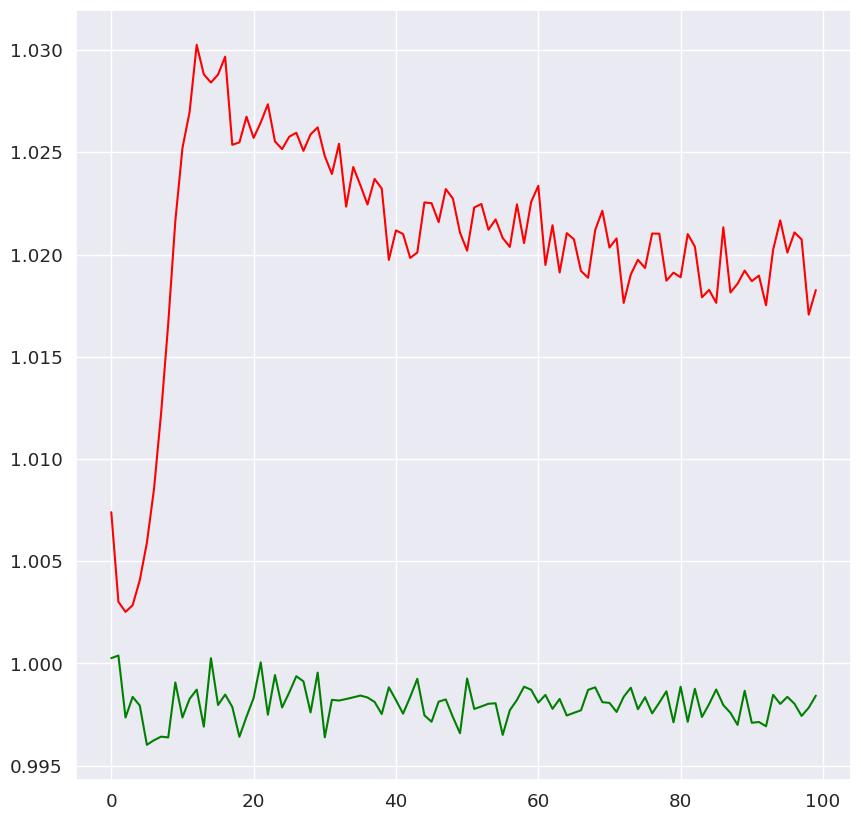

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.plot(np.arange(len(train_losses)), train_losses, color='green')
ax.plot(np.arange(len(val_losses)), val_losses, color='red')

#Hard

In [ ]:
train_losses, val_losses = fit(mnist_model, mnist_opt, mnist_scheduler, train, val, d_train, d_val, 100, device)

  0%|          | 0/100 [00:00<?, ?it/s]

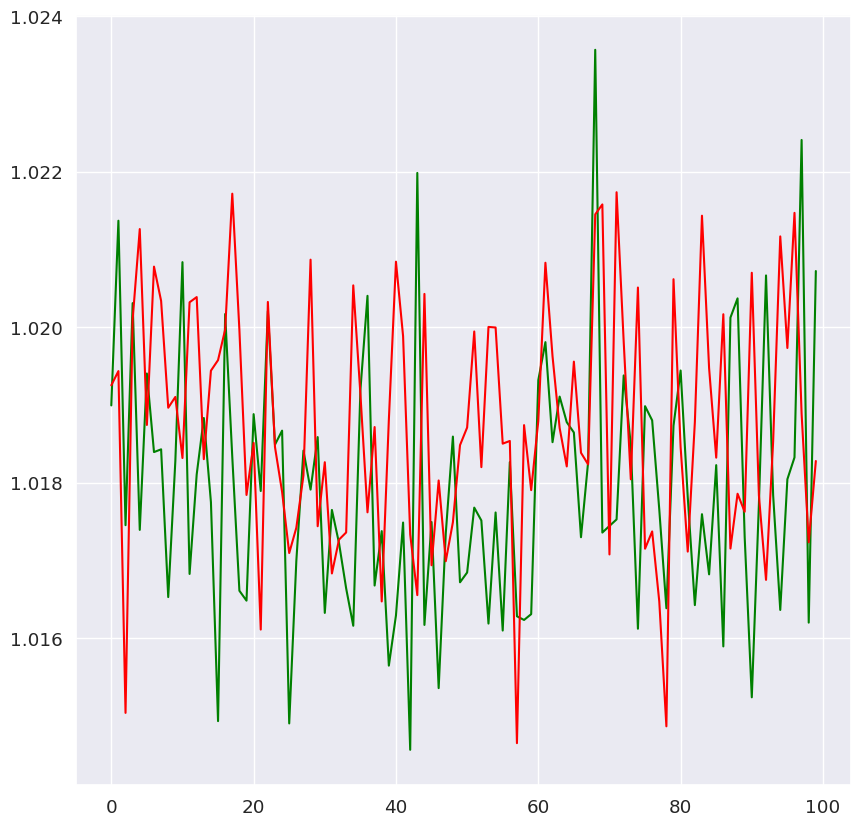

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.plot(np.arange(len(train_losses)), train_losses, color='green')
ax.plot(np.arange(len(val_losses)), val_losses, color='red')

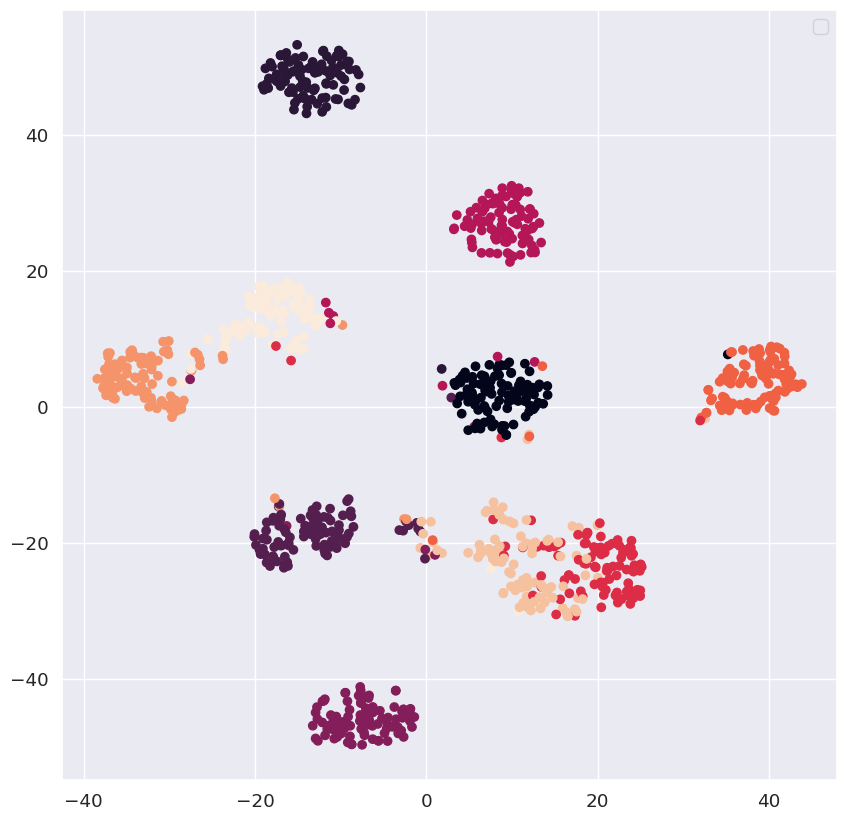

In [ ]:
bch, indices = get_mnist_triplet_batch(val, d_val)
embed_batch = torch.FloatTensor([]).view(-1, 4).to(device)
mnist_model.eval()
with torch.no_grad():
    bch = mnist_model(bch.to(device))

from sklearn.manifold import TSNE
reduced = TSNE().fit_transform(bch.cpu())
arr = np.arange(indices[-1])
# for i in range(len(indices)):
  # arr[:indices[-i]] = i
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.scatter(reduced[:, 0], reduced[:, 1], c=indices)
ax.legend()

In [ ]:
batch, labels = get_mnist_triplet_batch(train, d_train)
batch = mnist_model(batch.to(device))

In [ ]:
labels.size()[0]

1000

In [ ]:
a, p, n = get_semi_hard_triplets(batch, labels, device)
torch.set_printoptions(profile="full")

tensor([7.]) tensor([1.]) tensor([7.])


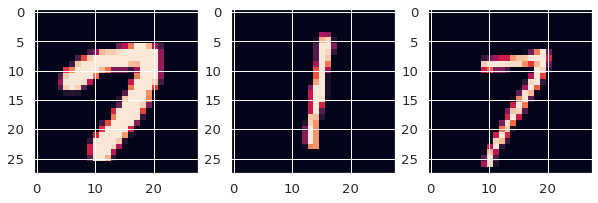

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(batch[3].squeeze(0))
ax[1].imshow(batch[7].squeeze(0))
ax[2].imshow(batch[37].squeeze(0))
print(labels[3], labels[7], labels[37])